In [28]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

c:\Users\DylanTong\AppData\Local\Programs\Python\Python310\lib\site-packages\bokeh\io\notebook.py:497: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

c:\Users\DylanTong\AppData\Local\Programs\Python\Python310\lib\site-packages\bokeh\io\notebook.py:497: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [7]:
filepath ='data/'
filename = 'geothermal-selected.csv'
raw_data = pd.read_csv(filepath + filename)

In [8]:
raw_data.info()
reindexed_data = raw_data['abstract']
reindexed_data.index = raw_data.index

reindexed_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                2324 non-null   object
 1   autor                2324 non-null   object
 2   doi                  2324 non-null   object
 3   citedby_count        2324 non-null   int64 
 4   affilname            2324 non-null   object
 5   affiliation-city     2324 non-null   object
 6   affiliation-country  2324 non-null   object
 7   abstract             2324 non-null   object
 8   topic                2324 non-null   object
dtypes: int64(1), object(8)
memory usage: 163.5+ KB


0    The range of As concentrations found in natura...
1    Arsenic's history in science, medicine and tec...
2    Subducted sediments play an important role in ...
3    This review deals with environmental origin, o...
4    The diagenetic cycling of carbon within recent...
Name: abstract, dtype: object

In [9]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

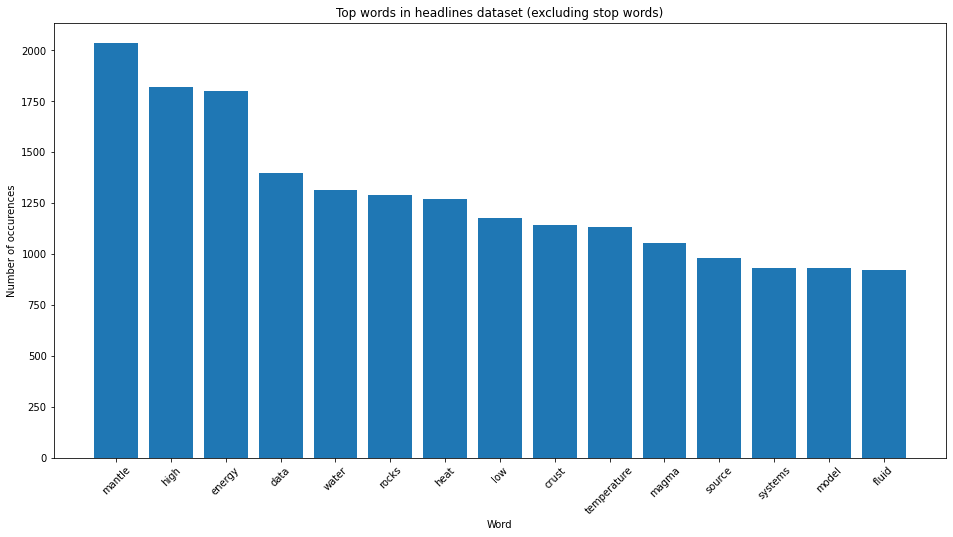

In [10]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation=45);
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [11]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: Energy resources and their utilization intimately relate to sustainable development. In attaining sustainable development, increasing the energy efficiencies of processes utilizing sustainable energy resources plays an important role. The utilization of renewable energy offers a wide range of exceptional benefits. There is also a link between exergy and sustainable development. A sustainable energy system may be regarded as a cost-efficient, reliable, and environmentally friendly energy system that effectively utilizes local resources and networks. Exergy analysis has been widely used in the design, simulation and performance evaluation of energy systems.
                  The present study comprehensively reviews exergetic analysis and performance evaluation of a wide range of renewable energy resources (RERs) for the first time to the best of the author's knowledge. In this regard, general relations (i.e., energy, exergy, entropy and exergy balance equa

In [12]:
n_topics = 2

In [13]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [14]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [15]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [16]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        # print('hello {}'.format(temp_vector_sum))
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [17]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  mantle high data rocks crust magma low water volcanic arc
Topic 2:  energy heat power systems renewable water thermal solar temperature paper


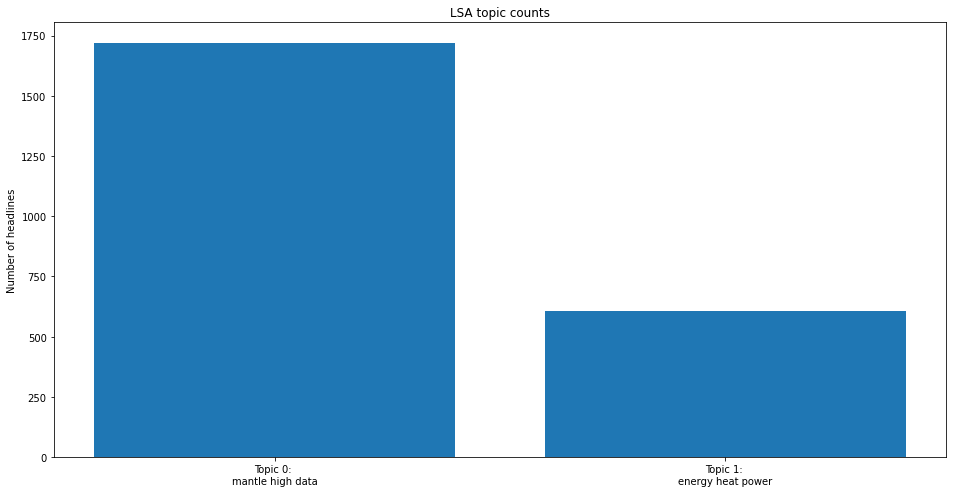

In [18]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [19]:
# LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [20]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [21]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  energy heat water temperature systems data high thermal results used
Topic 2:  mantle high rocks crust magma arc subduction melting continental low


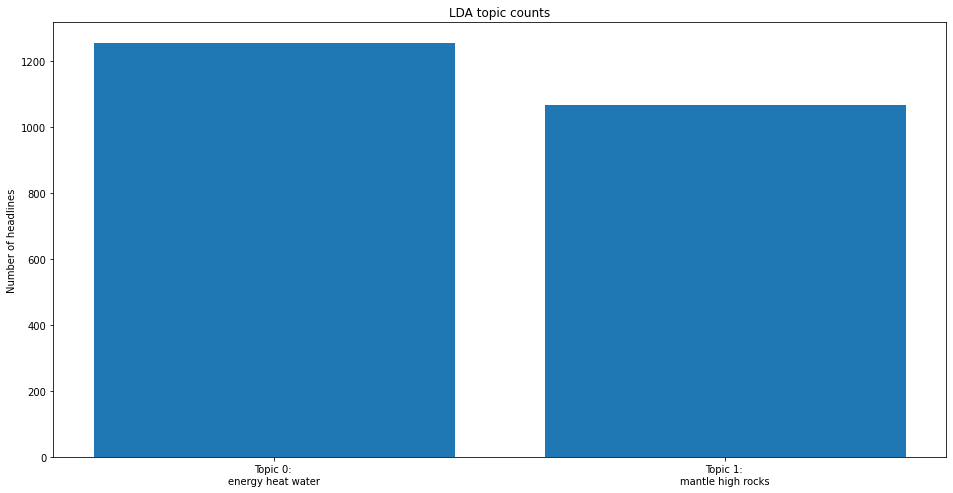

In [22]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [30]:
import pyLDAvis
import pyLDAvis.sklearn

In [31]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
docs_raw = raw_data.abstract
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)



In [33]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [34]:
pyLDAvis.sklearn.prepare(lda_tf,dtm_tf,tf_vectorizer)

c:\Users\DylanTong\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.137151 -0.184893       1        1  10.375216
14     0.207342  0.129102       2        1   9.284372
11     0.157300  0.131865       3        1   8.633238
2     -0.227117  0.038516       4        1   7.340687
6     -0.226805  0.131415       5        1   6.877638
4      0.128165 -0.154243       6        1   6.197635
0     -0.128872 -0.009559       7        1   5.969212
17    -0.057386  0.031436       8        1   5.290629
19     0.029533  0.029839       9        1   4.969888
10    -0.072750 -0.095134      10        1   4.823764
1      0.004812 -0.139449      11        1   4.329294
16     0.000205 -0.139344      12        1   4.051261
13     0.167156  0.041716      13        1   3.694180
7     -0.142454 -0.077760      14        1   3.655200
9      0.216663  0.045871      15        1   3.588688
5      0.134693 -0.114968      16        1   2.8405

单位产出